# Equilibrium examples
## Inverse Solve and Forward Solve for Grad-Shafranov Equilibria
This example notebook shows how to use FreeGSNKE to solve static Grad-Shafranov (GS) problems. Examples are provided for both inverse and forward solve modes. 

By forward solve mode, we refer to the case in which the coil currents are fixed by the user as inputs of the problem. Together with the profile parameterization the coild currents are used to obtain the GS equilibrium. 

By inverse solve mode, we refer to the case in which a set of coil currents are seeked so that the plasma is in some user-defined magnetic configuration. 

Below, we illustrate the mode aboves for plasmas in both diverted and limited configurations. 

FreeGSNKE adopts several functionalities from FreeGS, which we proceed to import.
If a version of FreeGSfast is available, it is recommended that is used instead. For instance, FreeGS can not handle plasmas in limiter configurations.

In [1]:
import freegs
import matplotlib.pyplot as plt
import numpy as np

## Create the machine object.

First, identify the files containing the machine description. FreeGSNKE requires the user to define the following environment variables:

ACTIVE_COILS_PATH , PASSIVE_COILS_PATH , WALL_PATH , LIMITER_PATH . These define the machine geometry and properties. 

The structure of the files containing the machine description is described in the notebook example_0 - machine_config. 

FreeGSNKE uses some of the base functionality provided by FreeGS to build "tokamak' machine objects, and the FreeGS public repository has some additional examples. 

The machine description adopted in this example has active coils as from UDA geometry for MAST-U.

In [2]:
import os
os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils_from_UDA.pickle"
os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils.pickle"
os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"
os.environ["LIMITER_PATH"] = "../machine_configs/MAST-U/limiter.pickle"
# the following environment variable is optional, 
# it contains data on an equilibrium that is representative for the tokamak 
# for more info please refer to Example_0
os.environ["EQUILIBRIUM_PATH"] = "../machine_configs/MAST-U/simple_initilization_equilibrium.pickle"

# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

No probe configuration is provided


## Instantiate an equilibrium

We are now ready to build a plasma equilibrium in the tokamak object. This is done using the `freegs.Equilibrium` class, which implicitly defines the rectangular domain of the solver as well as the grid resolution.

`Equilibrium` has sensible defaults, but it is recommended to define the radial and vertical domain of the grid using the `Rmin`, `Rmax`, `Zmin` and `Zmax` parameters, as well as the grid resolution in the radial and vertical directions with the `nx` and `ny` parameters.

A tokamak object should be supplied to the `tokamak` parameter to assign the desired machine to the equilibrium.

If available, an initial plasma flux function can be provided to the `psi` parameter (commented out in the following code).

In [3]:
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,   # Number of grid points in the radial direction
    ny=129,  # Number of grid points in the vertical direction
    # note that both nx and ny have to be of the form 2**i + 1 with i being an integer
    # psi=plasma_psi
)  

Equilibrium initialised using file provided as part of the machine description.


## Instantiate a profile object

A profile object can now be instantiated. This sets the parameterisation and properties of the profile function, as well as the value of the total plasma current.

The profiles used in this notebook follow the notation of Jeon (2015) for the toroidal plasma current:
$$j_{pl}=\lambda \left( 1-\psi_{n}^{\alpha_m} \right)^{\alpha_n}\left( \beta_{0}R/R_{0}+(1-\beta_{0}) R_{0}/R \right) $$ 
The first contribution is the pressure support $p'$, the second one is the toroidal-field support $f'f$.

FreeGSNKE accepts the same profile classes available in FreeGS: `ConstrainPaxisIp` or `ConstrainBetapIp`.
In the first case, the user defines the value of the plasma pressure at the magnetic axis, $p_a$. In the second case, the value of $\beta_p$, a proxy of the poloidal beta of the plasma is set.

The following example uses the `ConstrainPaxisIp` function, and an example demonstrating use of the `ConstrainBetapIp` function is in the following text cell.

Equilibrium (`eq`) and limiter (`tokamak.limiter`) objects are passed to the profile to inform calculations relating to the limiter.

The following parameters set the value for the profile properties.
- `paxis`: plasma pressure on axis [Pascals].
- `Ip`: total plasma current [Amps].
- `fvac`: vacuum toroidal field strength f = R * Bt.

The `alpha_m` and `alpha_n` coefficients define the 'peakedness' of the plasma current density distribution. See [this paper](https://arxiv.org/abs/1503.03135) for example. A Lau profile corresponds to `alpha_m=2` and `alpha_n=1`.

In [4]:
from freegsnke.jtor_update import ConstrainPaxisIp

profiles = ConstrainPaxisIp(
    eq=eq,
    limiter=tokamak.limiter,
    paxis=8e3,
    Ip=6e5,
    fvac=0.5,
    alpha_m=2,
    alpha_n=1
)

As promised, here is an example of using `ConstrainBetapIp` instead. The call signature is nearly identical, except the poloidal beta (`betap`) is used instead. 'betap' is a pure number.

```python
from freegsnke.jtor_update import ConstrainBetapIp
profiles = ConstrainBetapIp(
    eq=eq,
    limiter=tokamak.limiter,
    betap=0.05,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)
```

## Load the static nonlinear solver

We can now load FreeGSNKE's Grad-Shafranov static solver. The equilibrium is used to inform the solver of the computational domain and of the tokamak properties.
The solver below can be used for both inverse and forward solve modes, as exemplified below.

__NB__ It is not necessary to instantiate a new solver when aiming to use it on new or different equilibria, as long as the integration domain, mesh grid and tokamak are identical. 

In [5]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

## 1. Inverse solve

We start with an _inverse_ solve. In an inverse solve, we use a `constrain` object, which sets the desired magnetic constraints. 
FreeGSNKE uses FreeGS' `constrain` object, which accepts both constraints on the location of the X-points (`xpoints`) and constraints on the geometry of the last closed closed flux surface (`isoflux`).
In an inverse solve, the desired magnetic configuration described by the constrain object is used to seek a suitable set of coil currents. Both coil currents and the total flux $\psi(R,Z)$ are _outputs_.

Here, we specify a few constraints on the X-point position(s) and on some _isoflux_ points where $\psi(R,Z)$ should be the same.
This is identical to the FreeGS syntax, and we pass the instantiated equilibrium above the FreeGS `constrain` object.

In [6]:
# Set X-point coordinates
Rx = 0.6
Zx = 1.1
xpoints = [(Rx, -Zx),   
           (Rx,  Zx)]

# Set any desired isoflux constraints,
# these have structure (R1, Z1, R2, Z2)
# where (R1, Z1) and (R2, Z2) are 
# desired to be on the same flux contour.
Rmid = 1.4   # Outboard midplane
Rin = 0.35    # Inboard midplane
isoflux = [(Rx,Zx, Rx,-Zx), # link X-points
           (Rmid, 0, Rin, 0.0), # link inner and outer midplane points
           (Rmid, 0, Rx, Zx), # link outer midplane point and X-point

        #   some additional constraints
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),
           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]
           
# Instantiate the constrain object
constrain = freegs.control.constrain(xpoints=xpoints, 
                                     isoflux=isoflux,
                                     gamma=5e-7
                                    )

Since the problem is often underconstrained, we also specify the quadratic regularization parameter `gamma` (Tikhonov regularization in the quadratic least squares problem). Higher values of `gamma` encourage lower absolute coil current values. It is sometimes useful to experiment with different values of `gamma` to explore whether the converged solution departs from the desired constraints. 

Coil current values set as part of the equilibrium can be accessed using 
```python 
eq.tokamak['coil name'].current
```
For example, 
```python 
eq.tokamak['P6'].current
```
should return that the current in coil 'P6' is zero, as no currents have been assigned to the object eq.tokamak after this was initialised.

It is also possible to fix specific coil current values for individual coils, and toggle them off for the inverse solve. 
This means that the inverse solve procedure will not be allowed to vary those current values.
For instance, passive coils are automatically toggled off in during an inverse solve.

As an example, in the following we are fixing the `Solenoid` current to 5000 Amp and seeking a solution in which this value is fixed, rather than optimised by the inverse solve.

In [7]:
eq.tokamak['Solenoid'].current = 5000
eq.tokamak['Solenoid'].control = False

The following is the 'solve' call itself. Since a constrain object is provided, this is interpreted as an _inverse_ call and executed as such.
The 'target_relative_tolerance' is the maximum relative error on the plasma flux function allowed for convergence. 

In [8]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3)

The following shows how to display the resulting equilibrium, together with the imposed constraints.

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

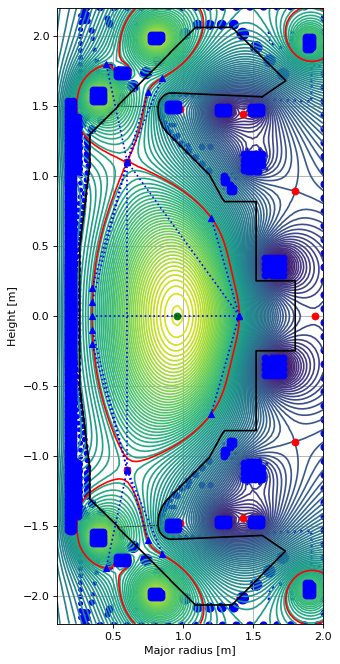

In [9]:
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

A solve call modifies the equilibrium object in place. 
The total flux can be accessed with `eq.psi()`, `eq.plasma_psi` is the contribution of the plasma alone.
The plasma current distribution over the domain can be found at `profiles.jtor`.

The set of optimised coil currents can be retrieved using `eq.tokamak.getCurrents()`.
These are now assigned to the equilibrium. 
The following saves these values for future use. 

In [10]:
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

### 2. Forward solve

As described before, in a forward solve we use some fixed coil current values as inputs, and solve for the corresponding equilibrium. 

As an example, we can use the set of currents identified in the inverse solve above.
Below we instantiate a new equilibrium and assign such current values to its tokamak.

In [11]:
eq_forward = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,   # Number of grid points in the radial direction
    ny=129,  # Number of grid points in the vertical direction
    # psi=plasma_psi
)  

import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    inverse_current_values = pickle.load(file=f)
for key in inverse_current_values.keys():
    eq_forward.tokamak[key].current = inverse_current_values[key]

Equilibrium initialised using file provided as part of the machine description.


The syntax of a _forward_ solve is identical to that of an inverse call: `GSStaticSolver.solve()`. However, the nonlinear solver is __NOT__ provided with a `constrain` object: `constrain=None` is used as an input. Therefore, coil current values are not changed and the solver uses them as inputs to calculate the appropriate flux function.

The forward nonlinear static solver in FreeGSNKE uses a Newton-Krylov implementation, which allows considerably more restrictive tolerance requests when compared to inverse solves. 

In [12]:
GSStaticSolver.solve(eq=eq_forward, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

In practice, with the above, we have improved on the equilibrium created in the inverse solve. Both coil currents and plasma profile properties have been kept the same, but the tolerance has improved substantially.

Since it is often difficult to achieve low relative tolerances in _inverse_ solve calls (for example, the above was set at a loose target_relative_tolerance=1e-3), the above strategy of using a forward solve after an inverse one is useful to obtain better equilibria.

We remark that the second forward call uses the coil current values obtained by the inverse solve above as inputs, to output a better flux function. 
In the forward call coil currents are not modified. 

As an additional example, below we manually vary some of the coil currents, perform new forward solves and compare the resulting equilibria.
Note that the manual current changes cause one of the equilibria to transition from a diverted to a limiter configuration (This is handled through FreeGSfast).

Now that the equilibrium is built, you can check what is the value of the parameter Beta0 corresponding to the requested pressure on axis:

In [13]:
profiles.Beta0

0.3665107566187872

It is possible to use Beta0 directly as an input parameter using the profile class `Fiesta_Topiol`. For example:

In [14]:
from freegsnke.jtor_update import Fiesta_Topiol

profiles_topiol = Fiesta_Topiol(
    eq=eq,
    limiter=tokamak.limiter,
    Beta0=0.3665,
    Ip=6e5,
    fvac=0.5,
    alpha_m=2,
    alpha_n=1
)

The below solves the GS problem using the profile object just defined

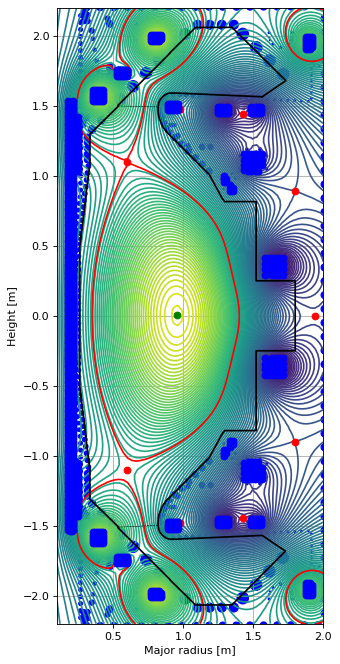

In [15]:
GSStaticSolver.solve(eq=eq_forward, 
                     profiles=profiles_topiol, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq_forward.tokamak.plot(axis=ax,show=False);

Let's now use a Lao profile to set up the same identical equilibrium (Lao et al. 1985 NuclFus 25).
In Topeol's profile above both Pprime and FFprime terms are propto (1-x^2), which correspond to 
alpha \propto beta \propto (1,0,-1)
We also need to take into account that alpha/beta = mu0
Therefore we have 

In [16]:
from freegsnke.jtor_update import Lao85
from freegs.gradshafranov import mu0

alpha = np.array([1,0,-1])
beta = (1 - profiles_topiol.Beta0)/profiles_topiol.Beta0 * alpha * mu0

profiles_lao = Lao85(
    eq=eq_forward,
    limiter=tokamak.limiter,
    Ip=6e5,
    fvac=0.5,
    alpha=alpha,
    beta=beta,
    alpha_logic=False,
    beta_logic=False,
)

Note that above we're providing as input the full list of alpha and beta coefficients, and therefore setting to False both logic inputs.
The following is entirely equivalent to the above:

In [17]:
alpha = np.array([1,0])
beta = (1 - profiles_topiol.Beta0)/profiles_topiol.Beta0 * alpha * mu0

profiles_lao = Lao85(
    eq=eq_forward,
    limiter=tokamak.limiter,
    Ip=6e5,
    fvac=0.5,
    alpha=alpha,
    beta=beta,
    alpha_logic=True,
    beta_logic=True,
)

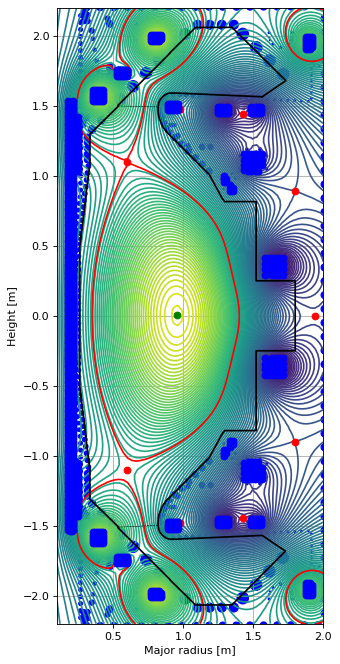

In [18]:
GSStaticSolver.solve(eq=eq_forward, 
                     profiles=profiles_lao, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq_forward.tokamak.plot(axis=ax,show=False);

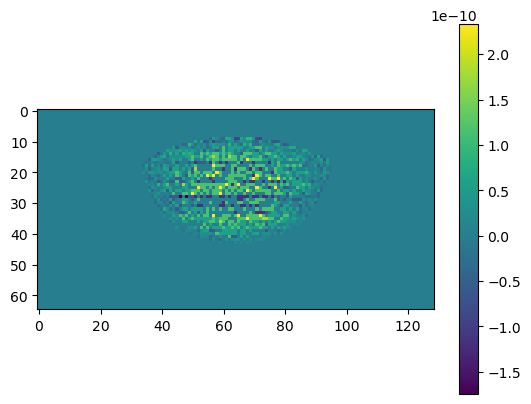

In [19]:
laoj = profiles_lao.Jtor(R=eq.R, Z=eq.Z, psi=eq_forward.psi())
topj = profiles_topiol.Jtor(R=eq.R, Z=eq.Z, psi=eq_forward.psi())

plt.imshow(laoj-topj)
plt.colorbar()